In [1]:
import spotipy
import pandas as pd
from spotipy.oauth2 import SpotifyClientCredentials # To access authorised Spotify data



## Part 1: Fetch data from Spotify API

In [2]:

CLIENT_ID = "" # Put your personal spotify client id
CLIENT_SECRET = "" # Put your personal spotify client secret

PLAYLIST_ID = '65GTUYlY3JCGhqCCP64cmR' # Spotify playlist id (can be obtained from the url)

# API Login
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager) #spotify object to access API



## Part 2: Analysis of a particular playlist (Global top 100)

In [3]:
from dateutil.parser import parse as parse_date
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
import spotipy.util as util


In [4]:
user_id="" #put your user_id

token = util.prompt_for_user_token(user_id,
                                   'playlist-read-collaborative',
                                   client_id=CLIENT_ID,
                                   client_secret=CLIENT_SECRET,
                                   redirect_uri='http://localhost:8000/')
sp = spotipy.Spotify(auth=token)

In [5]:
playlist = sp.user_playlist(user_id, PLAYLIST_ID)
tracks = playlist['tracks']['items']
next_uri = playlist['tracks']['next']
for _ in range(int(playlist['tracks']['total'] / playlist['tracks']['limit'])):
    response = sp._get(next_uri)
    tracks += response['items']
    next_uri = response['next']



In [6]:
tracks_df = pd.DataFrame([(track['track']['id'],
                           track['track']['artists'][0]['name'],
                           track['track']['name'],
                           parse_date(track['track']['album']['release_date']) if track['track']['album']['release_date'] else None,
                           parse_date(track['added_at']))
                          for track in playlist['tracks']['items']],
                         columns=['id', 'artist', 'name', 'release_date', 'added_at'] )

In [7]:
tracks_df.head(10)

,id,artist,name,release_date,added_at
0,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,2017-03-03,2017-11-07 20:08:39+00:00
1,7wGoVu4Dady5GV0Sv4UIsx,Post Malone,rockstar,2017-09-15,2017-12-10 18:51:43+00:00
2,1xznGGDReH1oQq0xzbwXa3,Drake,One Dance,2016-05-06,2016-07-02 23:19:37+00:00
3,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers,Closer,2016-07-29,2016-10-06 03:00:48+00:00
4,34gCuhDGsG4bRPIf9bb02f,Ed Sheeran,Thinking out Loud,2014-06-21,2015-10-16 22:56:43+00:00
5,2XW4DbS6NddZxRPm5rMCeY,Drake,God's Plan,2018-01-20,2018-04-05 21:21:58+00:00
6,5ZULALImTm80tzUbYQYM9d,Tones And I,Dance Monkey,2019-08-29,2020-02-11 02:24:50+00:00
7,3KkXRkHbMCARz0aVfEt68P,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,2018-12-14,2019-06-28 17:41:08+00:00
8,1rfofaqEpACxVEHIZBJe6W,Camila Cabello,Havana (feat. Young Thug),2018-01-12,2018-03-06 01:46:33+00:00
9,0tgVpDi06FyKpA1z0VMD4v,Ed Sheeran,Perfect,2017-03-03,2018-03-05 22:09:41+00:00


#### Top artists

In [8]:
tracks_df \
    .groupby('artist') \
    .count()['id'] \
    .reset_index() \
    .sort_values('id', ascending=False) \
    .rename(columns={'id': 'amount'}) \
    .head(10)

,artist,amount
57,Post Malone,6
23,Ed Sheeran,5
10,Blacklite District,5
29,Imagine Dragons,4
62,Shawn Mendes,3
21,Drake,3
66,The Chainsmokers,3
68,The Weeknd,3
72,Twenty One Pilots,3
34,Justin Bieber,3


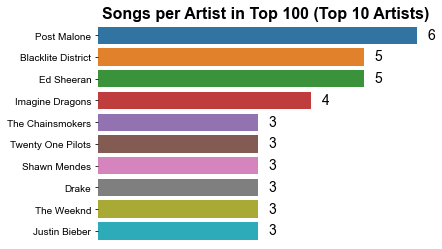

In [9]:
descending_order = tracks_df['artist'].value_counts().sort_values(ascending=False).head(10).index
ax = sns.countplot(y = tracks_df['artist'], order=descending_order)

sns.despine(fig=None, ax=None, top=True, right=True, left=False, trim=False)
sns.set(rc={'figure.figsize':(8,12)})

ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title('Songs per Artist in Top 100 (Top 10 Artists)', fontsize=16, fontweight='heavy')
sns.set(font_scale = 1)
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)

y = tracks_df['artist'].value_counts().sort_values(ascending=False).head(10)
for i, v in enumerate(y):
    ax.text(v + 0.2, i + .16, str(v), color='black', fontweight='light', fontsize=14)
    
plt.show()


#### Top artists by year

In [10]:
counted_year_df = tracks_df \
    .assign(year_added=tracks_df.added_at.dt.year) \
    .groupby(['artist', 'year_added']) \
    .count()['id'] \
    .reset_index() \
    .rename(columns={'id': 'amount'}) \
    .sort_values('amount', ascending=False)

in_top_5_year_artist = counted_year_df \
    .groupby('year_added') \
    .head(5) \
    .artist \
    .unique()

counted_year_df \
    [counted_year_df.artist.isin(in_top_5_year_artist)] \
    .pivot('artist', 'year_added', 'amount') \
    .fillna(0) \
    .style.background_gradient()

year_added,2015,2016,2017,2018,2019,2020
artist,,,,,,
Ariana Grande,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
Blacklite District,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000
Camila Cabello,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
Drake,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
Dua Lipa,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
Ed Sheeran,2.000000,0.000000,1.000000,1.000000,0.000000,1.000000
Imagine Dragons,2.000000,0.000000,1.000000,1.000000,0.000000,0.000000
Justin Bieber,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
Lil Uzi Vert,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000


#### Audio features

In [11]:
features = []
for n, chunk_series in tracks_df.groupby(np.arange(len(tracks_df)) // 50).id:
    features += sp.audio_features([*map(str, chunk_series)])
features_df = pd.DataFrame.from_dict(filter(None, features))
tracks_with_features_df = tracks_df.merge(features_df, on=['id'], how='inner')

In [12]:
tracks_with_features_df.head()


,id,artist,name,release_date,added_at,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,2017-03-03,2017-11-07 20:08:39+00:00,0.825,0.652,1,-3.183,0,...,0.00000,0.0931,0.931,95.977,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4
1,7wGoVu4Dady5GV0Sv4UIsx,Post Malone,rockstar,2017-09-15,2017-12-10 18:51:43+00:00,0.577,0.522,5,-6.594,0,...,0.00009,0.1420,0.119,159.772,audio_features,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4
2,1xznGGDReH1oQq0xzbwXa3,Drake,One Dance,2016-05-06,2016-07-02 23:19:37+00:00,0.791,0.619,1,-5.886,1,...,0.00423,0.3510,0.371,103.989,audio_features,spotify:track:1xznGGDReH1oQq0xzbwXa3,https://api.spotify.com/v1/tracks/1xznGGDReH1o...,https://api.spotify.com/v1/audio-analysis/1xzn...,173987,4
3,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers,Closer,2016-07-29,2016-10-06 03:00:48+00:00,0.748,0.524,8,-5.599,1,...,0.00000,0.1110,0.661,95.010,audio_features,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
4,34gCuhDGsG4bRPIf9bb02f,Ed Sheeran,Thinking out Loud,2014-06-21,2015-10-16 22:56:43+00:00,0.781,0.445,2,-6.061,1,...,0.00000,0.1840,0.591,78.998,audio_features,spotify:track:34gCuhDGsG4bRPIf9bb02f,https://api.spotify.com/v1/tracks/34gCuhDGsG4b...,https://api.spotify.com/v1/audio-analysis/34gC...,281560,4


#### Danceability

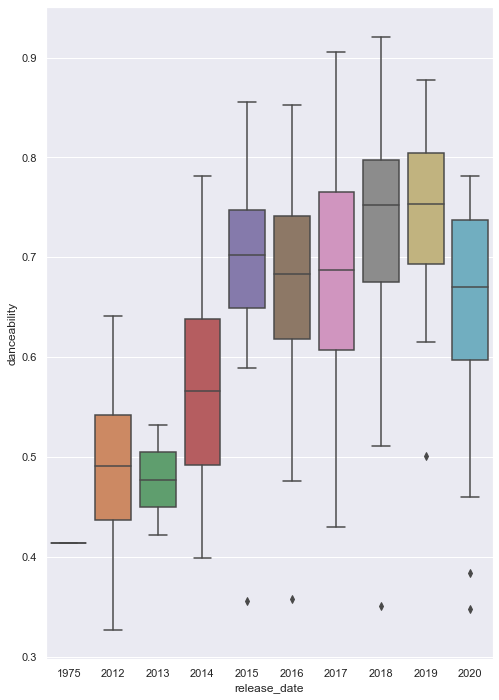

In [13]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.danceability)

#### Energy

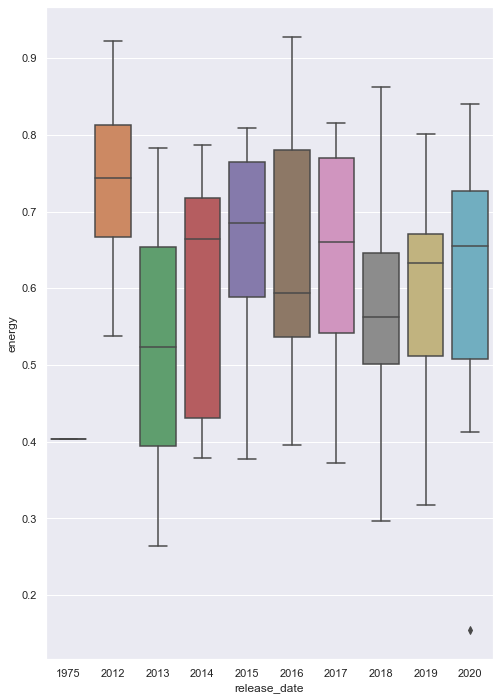

In [14]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.energy)

#### Loudness

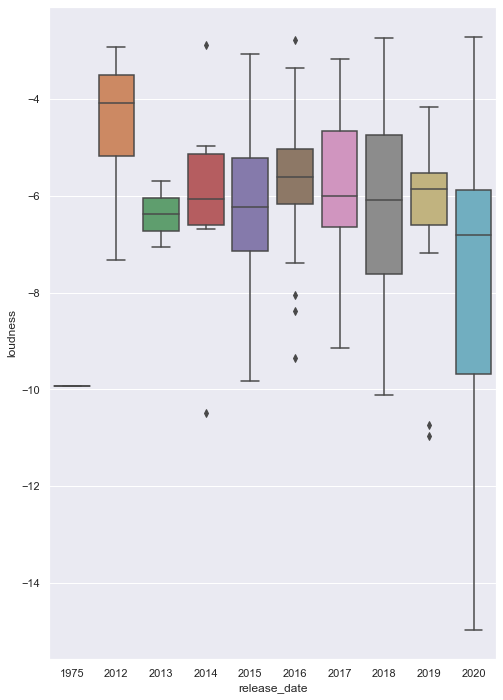

In [15]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.loudness)

#### Acousticness

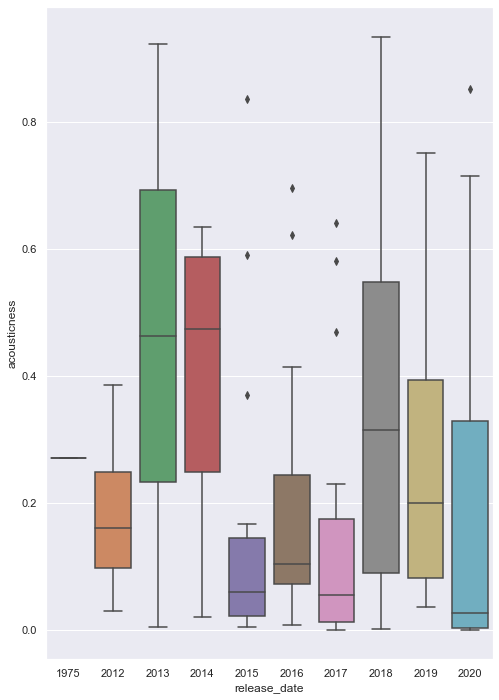

In [16]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.acousticness)

#### Instrumentalness

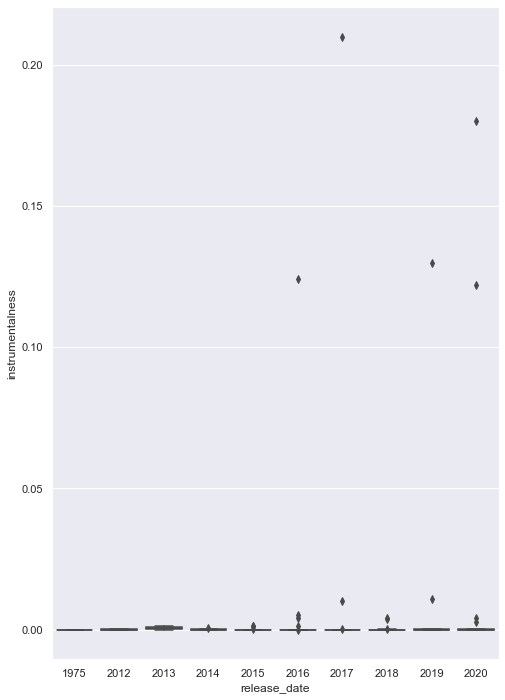

In [17]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.instrumentalness)

#### Liveness

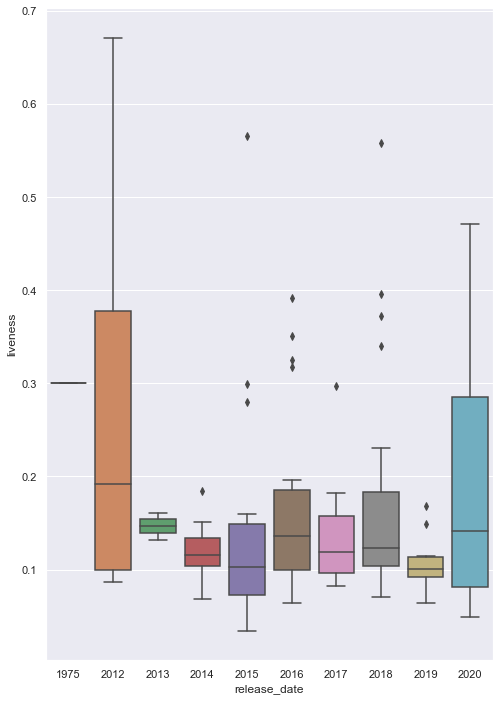

In [18]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.liveness)

#### Speechiness

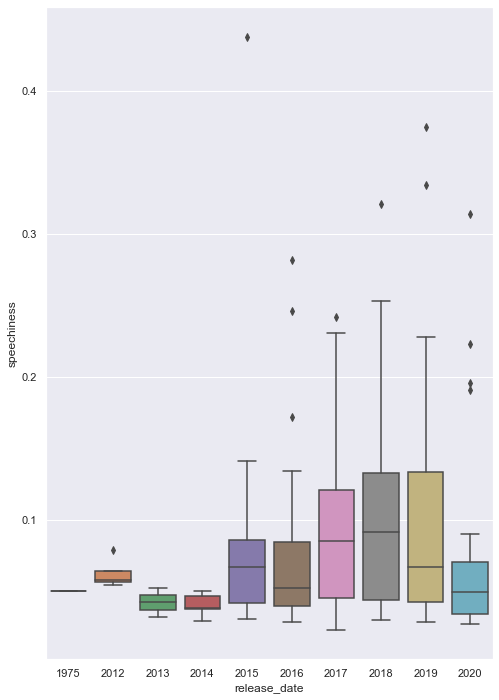

In [19]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.speechiness)

#### Tempo

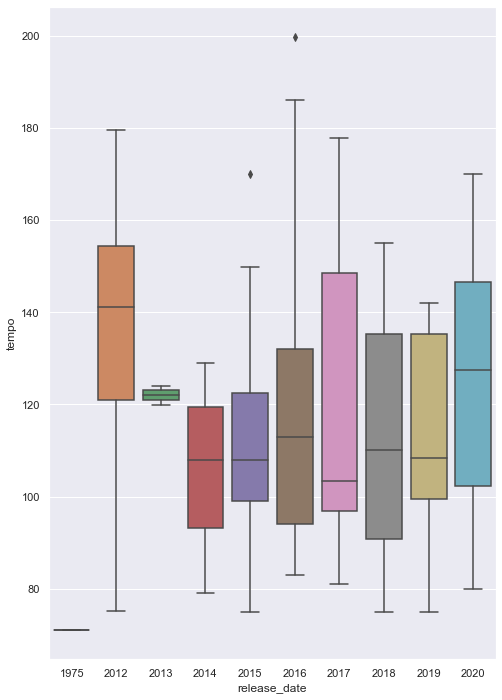

In [20]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.tempo)

#### Valence

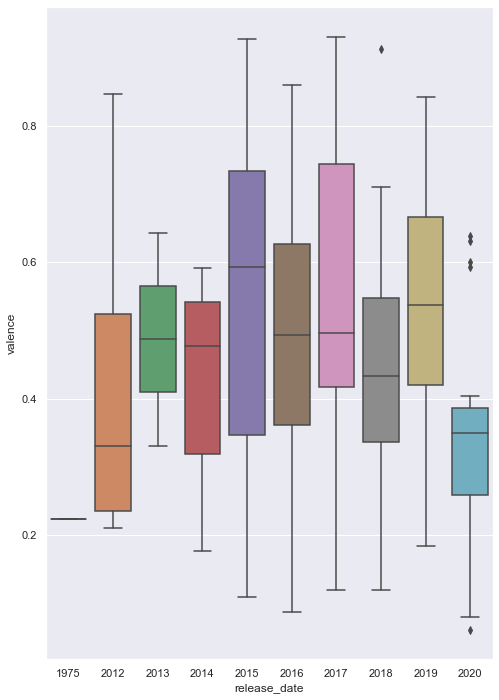

In [21]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.year,
            y=tracks_with_features_df.valence)

#### Seasonality x danceability

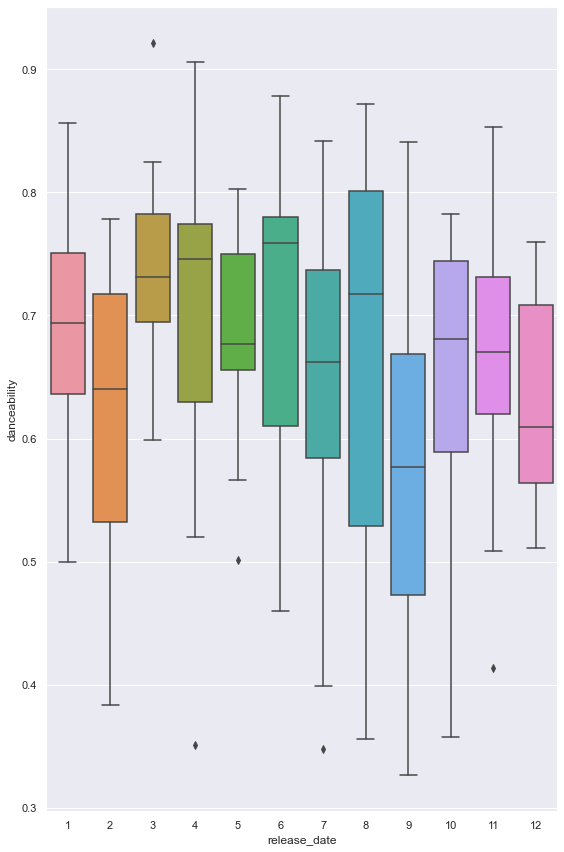

In [22]:
sns.boxplot(x=tracks_with_features_df.release_date.dt.month, y=tracks_with_features_df.danceability)
plt.tight_layout()

#### Seasonality x valence

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


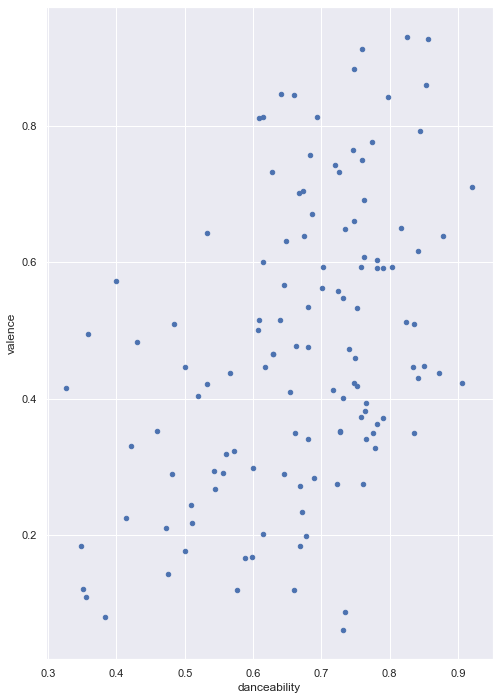

In [23]:
tracks_with_features_df.plot(kind='scatter', x='danceability', y='valence')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


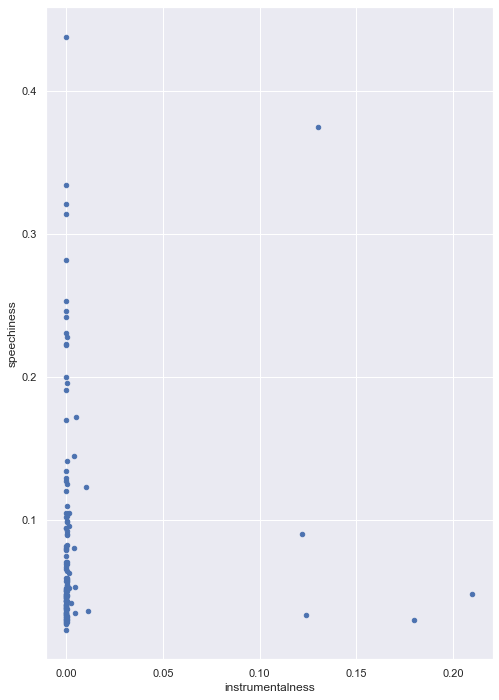

In [24]:
tracks_with_features_df.plot(kind='scatter', x='instrumentalness', y='speechiness')


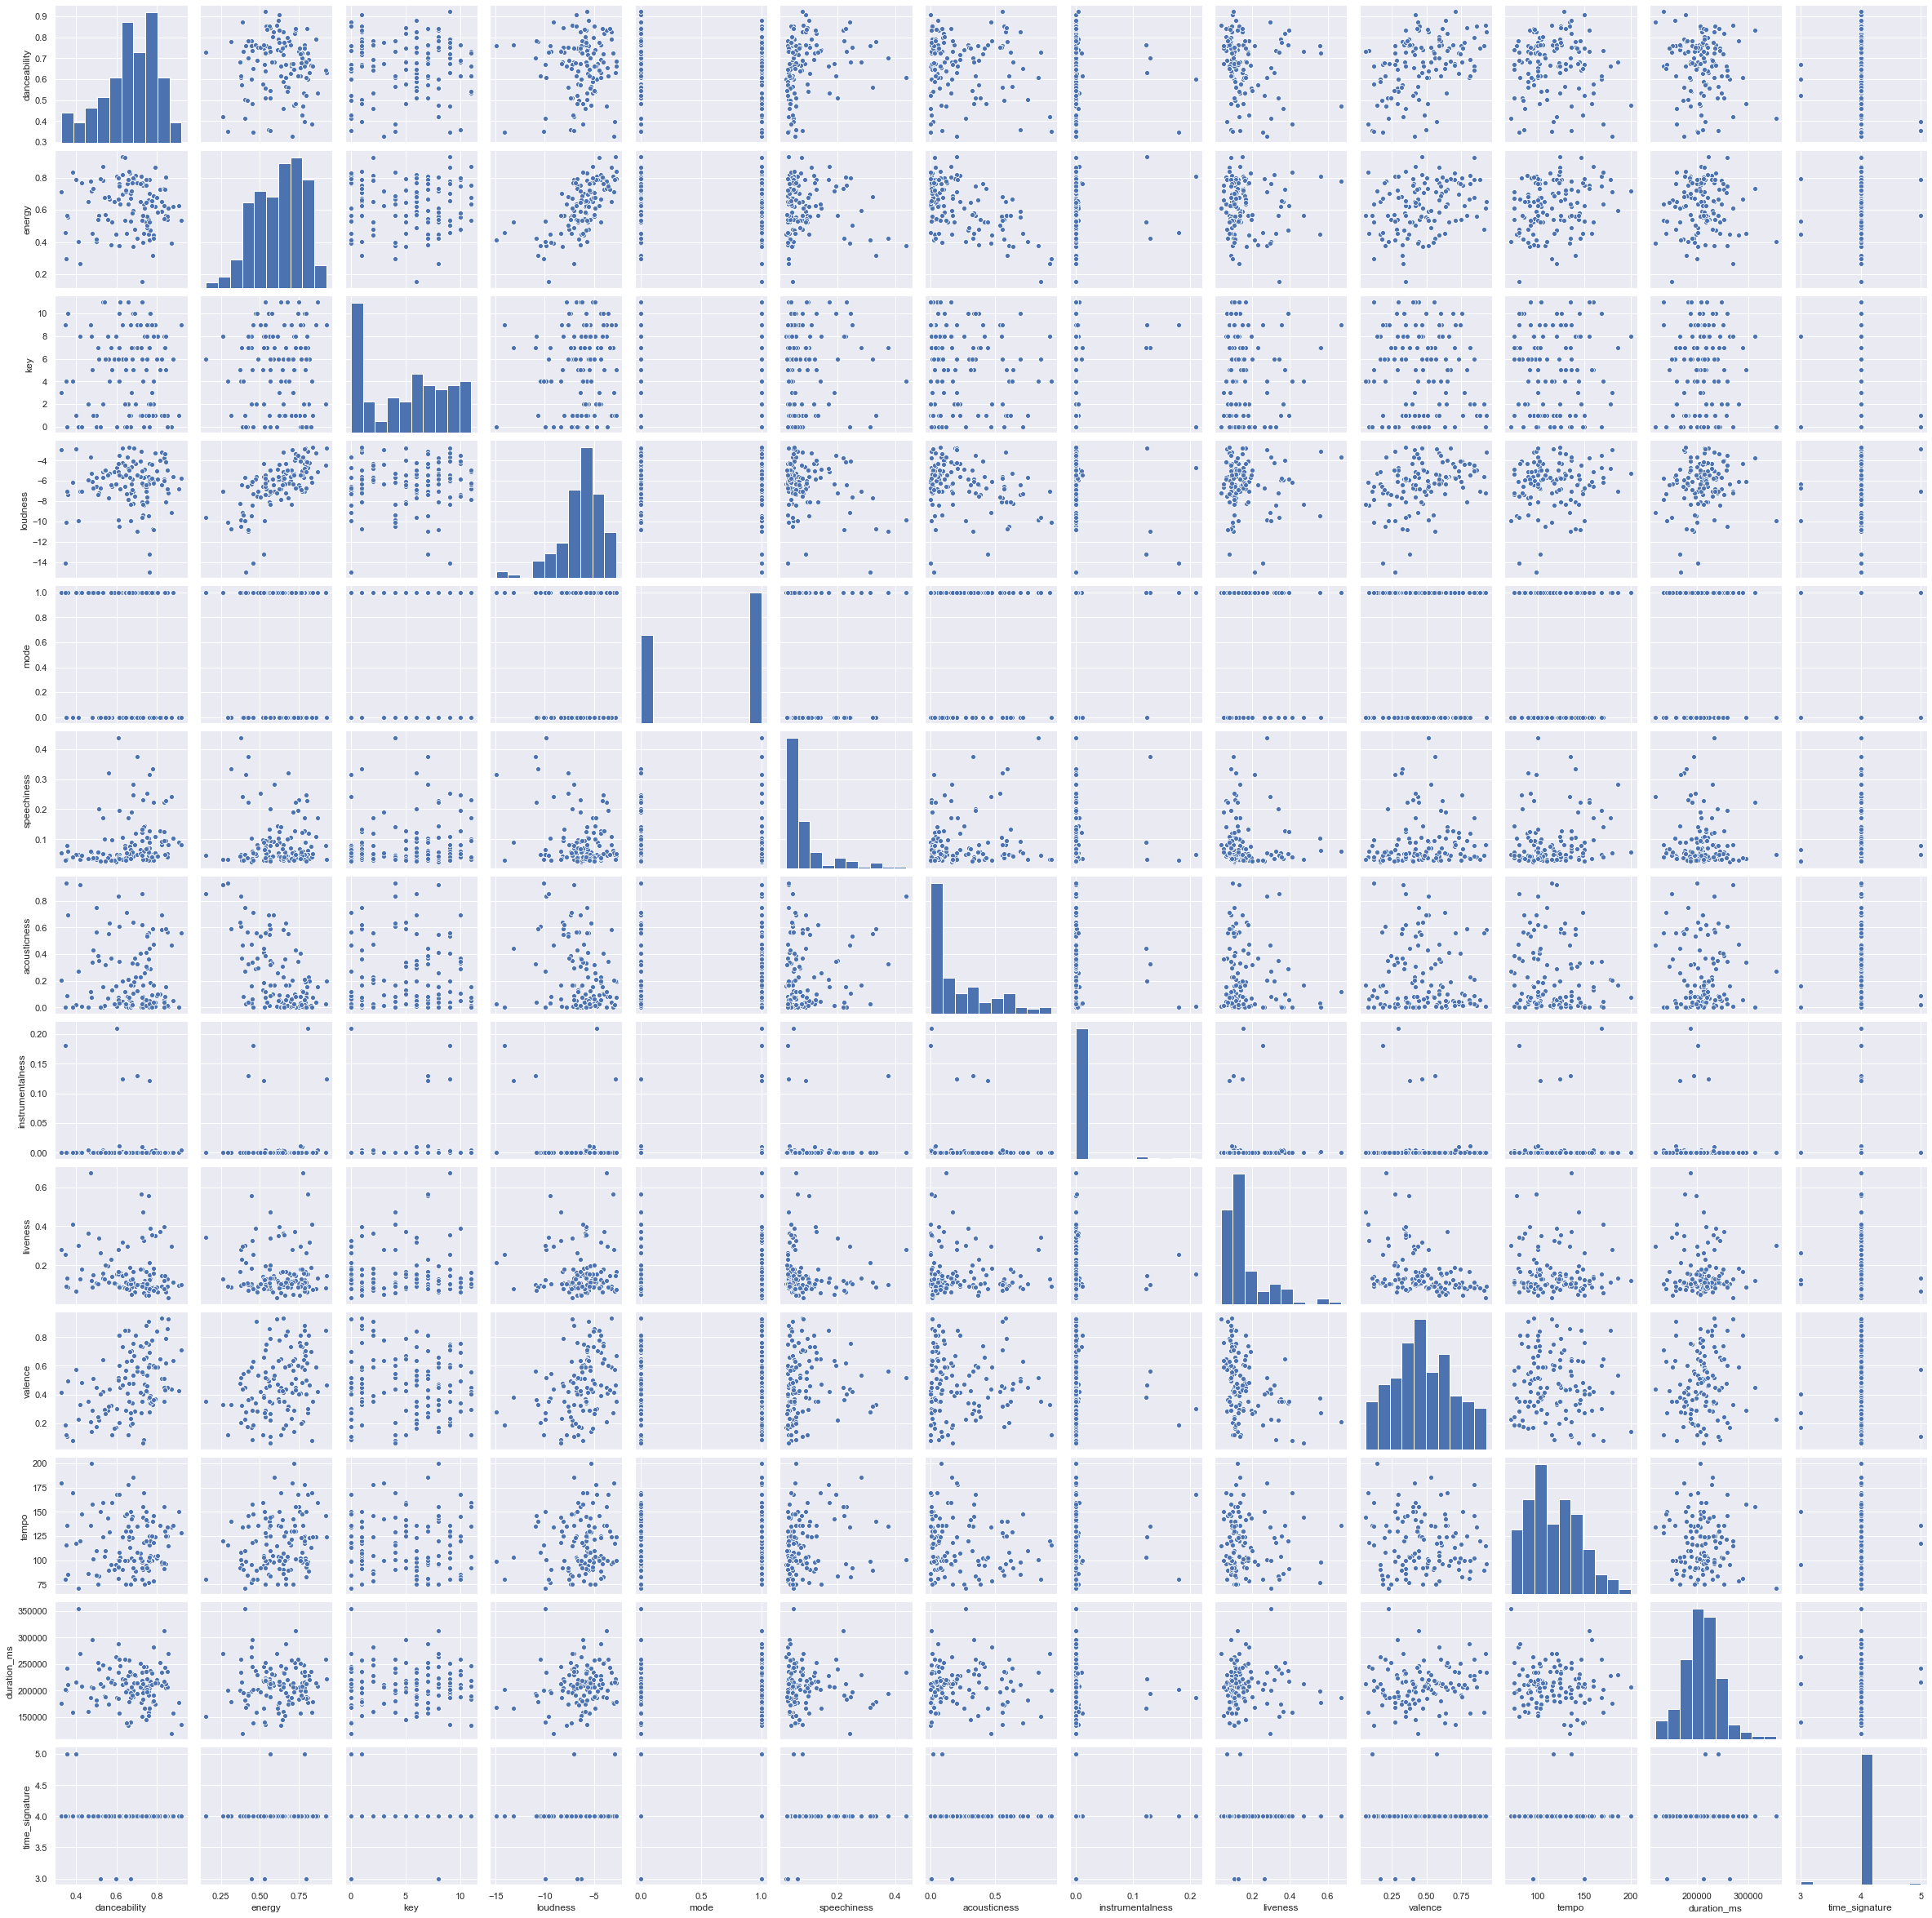

In [25]:
scatterplots = sns.pairplot(tracks_with_features_df)
scatterplots

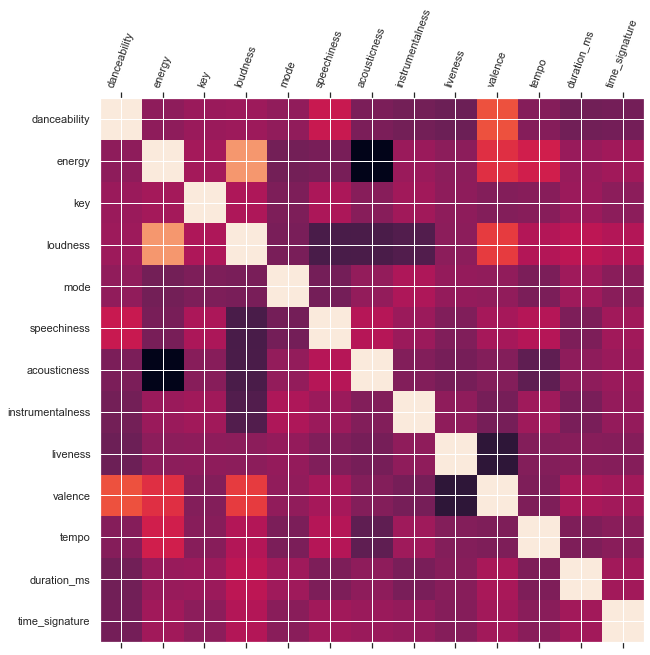

In [26]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    
    plt.xticks(rotation=70)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
plot_corr(tracks_with_features_df)

### Vector distance

In [27]:
tracks_with_features_df.head()

,id,artist,name,release_date,added_at,danceability,energy,key,loudness,mode,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,2017-03-03,2017-11-07 20:08:39+00:00,0.825,0.652,1,-3.183,0,...,0.00000,0.0931,0.931,95.977,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4
1,7wGoVu4Dady5GV0Sv4UIsx,Post Malone,rockstar,2017-09-15,2017-12-10 18:51:43+00:00,0.577,0.522,5,-6.594,0,...,0.00009,0.1420,0.119,159.772,audio_features,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4
2,1xznGGDReH1oQq0xzbwXa3,Drake,One Dance,2016-05-06,2016-07-02 23:19:37+00:00,0.791,0.619,1,-5.886,1,...,0.00423,0.3510,0.371,103.989,audio_features,spotify:track:1xznGGDReH1oQq0xzbwXa3,https://api.spotify.com/v1/tracks/1xznGGDReH1o...,https://api.spotify.com/v1/audio-analysis/1xzn...,173987,4
3,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers,Closer,2016-07-29,2016-10-06 03:00:48+00:00,0.748,0.524,8,-5.599,1,...,0.00000,0.1110,0.661,95.010,audio_features,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4
4,34gCuhDGsG4bRPIf9bb02f,Ed Sheeran,Thinking out Loud,2014-06-21,2015-10-16 22:56:43+00:00,0.781,0.445,2,-6.061,1,...,0.00000,0.1840,0.591,78.998,audio_features,spotify:track:34gCuhDGsG4bRPIf9bb02f,https://api.spotify.com/v1/tracks/34gCuhDGsG4b...,https://api.spotify.com/v1/audio-analysis/34gC...,281560,4


In [28]:
encode_fields = [
    'danceability',
    'energy',
    'key',
    'loudness',
    'mode',
    'speechiness',
    'acousticness',
    'instrumentalness',
    'liveness',
    'valence',
    'tempo',
    'duration_ms',
    'time_signature',
]

def encode(row):
    return np.array([
        (row[k] - tracks_with_features_df[k].min())
        / (tracks_with_features_df[k].max() - tracks_with_features_df[k].min())
        for k in encode_fields])

tracks_with_features_encoded_df = tracks_with_features_df.assign(
    encoded=tracks_with_features_df.apply(encode, axis=1))

In [29]:
tracks_with_features_encoded_df.head()


,id,artist,name,release_date,added_at,danceability,energy,key,loudness,mode,...,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature,encoded
0,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,2017-03-03,2017-11-07 20:08:39+00:00,0.825,0.652,1,-3.183,0,...,0.0931,0.931,95.977,audio_features,spotify:track:7qiZfU4dY1lWllzX7mPBI3,https://api.spotify.com/v1/tracks/7qiZfU4dY1lW...,https://api.spotify.com/v1/audio-analysis/7qiZ...,233713,4,"[0.8383838383838381, 0.6429495472186287, 0.090..."
1,7wGoVu4Dady5GV0Sv4UIsx,Post Malone,rockstar,2017-09-15,2017-12-10 18:51:43+00:00,0.577,0.522,5,-6.594,0,...,0.1420,0.119,159.772,audio_features,spotify:track:7wGoVu4Dady5GV0Sv4UIsx,https://api.spotify.com/v1/tracks/7wGoVu4Dady5...,https://api.spotify.com/v1/audio-analysis/7wGo...,218320,4,"[0.42087542087542074, 0.47477360931435963, 0.4..."
2,1xznGGDReH1oQq0xzbwXa3,Drake,One Dance,2016-05-06,2016-07-02 23:19:37+00:00,0.791,0.619,1,-5.886,1,...,0.3510,0.371,103.989,audio_features,spotify:track:1xznGGDReH1oQq0xzbwXa3,https://api.spotify.com/v1/tracks/1xznGGDReH1o...,https://api.spotify.com/v1/audio-analysis/1xzn...,173987,4,"[0.781144781144781, 0.6002587322121603, 0.0909..."
3,7BKLCZ1jbUBVqRi2FVlTVw,The Chainsmokers,Closer,2016-07-29,2016-10-06 03:00:48+00:00,0.748,0.524,8,-5.599,1,...,0.1110,0.661,95.010,audio_features,spotify:track:7BKLCZ1jbUBVqRi2FVlTVw,https://api.spotify.com/v1/tracks/7BKLCZ1jbUBV...,https://api.spotify.com/v1/audio-analysis/7BKL...,244960,4,"[0.7087542087542086, 0.47736093143596375, 0.72..."
4,34gCuhDGsG4bRPIf9bb02f,Ed Sheeran,Thinking out Loud,2014-06-21,2015-10-16 22:56:43+00:00,0.781,0.445,2,-6.061,1,...,0.1840,0.591,78.998,audio_features,spotify:track:34gCuhDGsG4bRPIf9bb02f,https://api.spotify.com/v1/tracks/34gCuhDGsG4b...,https://api.spotify.com/v1/audio-analysis/34gC...,281560,4,"[0.7643097643097643, 0.3751617076326003, 0.181..."


In [30]:
tracks_with_features_encoded_product_df = tracks_with_features_encoded_df \
    .assign(temp=0) \
    .merge(tracks_with_features_encoded_df.assign(temp=0), on='temp', how='left') \
    .drop(columns='temp')
tracks_with_features_encoded_product_df = tracks_with_features_encoded_product_df[
    tracks_with_features_encoded_product_df.id_x != tracks_with_features_encoded_product_df.id_y
]
tracks_with_features_encoded_product_df['merge_id'] = tracks_with_features_encoded_product_df \
    .apply(lambda row: ''.join(sorted([row['id_x'], row['id_y']])), axis=1)
tracks_with_features_encoded_product_df['distance'] = tracks_with_features_encoded_product_df \
    .apply(lambda row: np.linalg.norm(row['encoded_x'] - row['encoded_y']), axis=1)


#### The most similar songs¶

In [31]:
tracks_with_features_encoded_product_df \
    .sort_values('distance') \
    .drop_duplicates('merge_id') \
    [['artist_x', 'name_x', 'release_date_x', 'artist_y', 'name_y', 'release_date_y', 'distance']] \
    .head(10)

,artist_x,name_x,release_date_x,artist_y,name_y,release_date_y,distance
10738,Dua Lipa,IDGAF,2017-06-02,Fifth Harmony,Work from Home (feat. Ty Dolla $ign),2016-05-27,0.218866
5109,Sia,Cheap Thrills,2016-01-29,Mike Posner,I Took A Pill In Ibiza - Seeb Remix,2015-07-24,0.219636
1937,Imagine Dragons,Believer,2017-06-23,Calvin Harris,One Kiss (with Dua Lipa),2018-04-06,0.222758
2423,Dua Lipa,New Rules,2017-06-02,The Weeknd,Can't Feel My Face,2015-08-28,0.226079
1045,Camila Cabello,Havana (feat. Young Thug),2018-01-12,Ariana Grande,"thank u, next",2019-02-08,0.262603
1879,Imagine Dragons,Believer,2017-06-23,Dua Lipa,New Rules,2017-06-02,0.280909
3205,Mike Posner,I Took A Pill In Ibiza - Seeb Remix,2015-07-24,MaRiOnA,Je manque de Toi,2019-09-03,0.283326
8333,The Weeknd,Can't Feel My Face,2015-08-28,Mike Posner,I Took A Pill In Ibiza - Seeb Remix,2015-07-24,0.285252
323,Drake,One Dance,2016-05-06,Drake,In My Feelings,2018-06-29,0.299240
6667,Ariana Grande,"thank u, next",2019-02-08,Kygo,It Ain't Me (with Selena Gomez),2017-02-16,0.300184


#### The most different songs

In [32]:
tracks_with_features_encoded_product_df \
    .sort_values('distance', ascending=False) \
    .drop_duplicates('merge_id') \
    [['artist_x', 'name_x', 'release_date_x', 'artist_y', 'name_y', 'release_date_y', 'distance']] \
    .head(10)

,artist_x,name_x,release_date_x,artist_y,name_y,release_date_y,distance
119,Ed Sheeran,Shape of You,2017-03-03,G.H.T,Alone,2020-07-01,2.237148
6195,XXXTENTACION,Jocelyn Flores,2017-08-25,G.H.T,Alone,2020-07-01,2.063217
14877,G.H.T,Alone,2020-07-01,sophiemarie.b,Shameless,2020-07-10,2.062186
14799,G.H.T,Alone,2020-07-01,Ariana Grande,7 rings,2019-02-08,2.039403
10812,Billie Eilish,lovely (with Khalid),2018-04-19,Imagine Dragons,Thunder,2017-06-23,2.036897
7918,Calvin Harris,This Is What You Came For (feat. Rihanna),2016-04-29,Kendog,Back to Back,2020-05-16,2.035685
11775,XXXTENTACION,Moonlight,2018-03-16,G.H.T,Alone,2020-07-01,2.031246
10850,Billie Eilish,lovely (with Khalid),2018-04-19,Travis Scott,SICKO MODE,2018-08-03,2.011019
5400,Ariana Grande,7 rings,2019-02-08,Imagine Dragons,Radioactive,2012-09-04,2.007699
5295,Mark Ronson,Uptown Funk (feat. Bruno Mars),2015-01-12,Billie Eilish,lovely (with Khalid),2018-04-19,2.007592


#### The most average songs

In [33]:
tracks_with_features_encoded_product_df \
    .groupby(['artist_x', 'name_x', 'release_date_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance') \
    .head(10)

,artist_x,name_x,release_date_x,distance
78,OMI,Cheerleader - Felix Jaehn Remix Radio Edit,2015-10-16,119.216064
43,Halsey,Without Me,2018-10-04,119.961004
96,Shaylen,Sprite,2019-11-08,122.872424
6,Ariana Grande,"thank u, next",2019-02-08,122.904726
20,Camila Cabello,Havana (feat. Young Thug),2018-01-12,124.150029
40,Fifth Harmony,Work from Home (feat. Ty Dolla $ign),2016-05-27,124.873941
82,Post Malone,Congratulations,2016-12-09,124.919776
33,Dua Lipa,IDGAF,2017-06-02,124.962426
76,Marshmello,Happier,2018-08-17,125.633030
112,Twenty One Pilots,Ride,2015-05-15,126.153446


#### The most outstanding songs¶

In [34]:
tracks_with_features_encoded_product_df \
    .groupby(['artist_x', 'name_x', 'release_date_x']) \
    .sum()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artist_x,name_x,release_date_x,distance
42,G.H.T,Alone,2020-07-01,203.657142
11,Billie Eilish,lovely (with Khalid),2018-04-19,191.035944
48,Imagine Dragons,Thunder,2017-06-23,190.515821
53,Justin Bieber,Love Yourself,2015-11-13,186.083381
87,Queen,Bohemian Rhapsody - 2011 Mix,1975-11-21,185.986697
57,Kendog,Back to Back,2020-05-16,179.944898
5,Ariana Grande,7 rings,2019-02-08,179.050639
106,The Weeknd,The Hills,2015-08-28,176.587912
121,sophiemarie.b,Call Me Up,2020-06-05,174.935893
14,Blacklite District,Falling,2020-02-14,174.720606


#### The most outstanding artists¶

In [35]:
tracks_with_features_encoded_product_df \
    .groupby(['artist_x']) \
    .mean()['distance'] \
    .reset_index() \
    .sort_values('distance', ascending=False) \
    .head(10)

,artist_x,distance
26,G.H.T,1.655749
58,Queen,1.512087
9,Billie Eilish,1.486289
36,Kendog,1.462967
32,John Legend,1.412860
78,sophiemarie.b,1.383756
29,Imagine Dragons,1.355156
34,Justin Bieber,1.309179
20,Djoko,1.304342
31,James Arthur,1.300799


## Part 3: K-means clustering of songs on basis of audio features:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdcd2303bd0>,
      dtype=object)

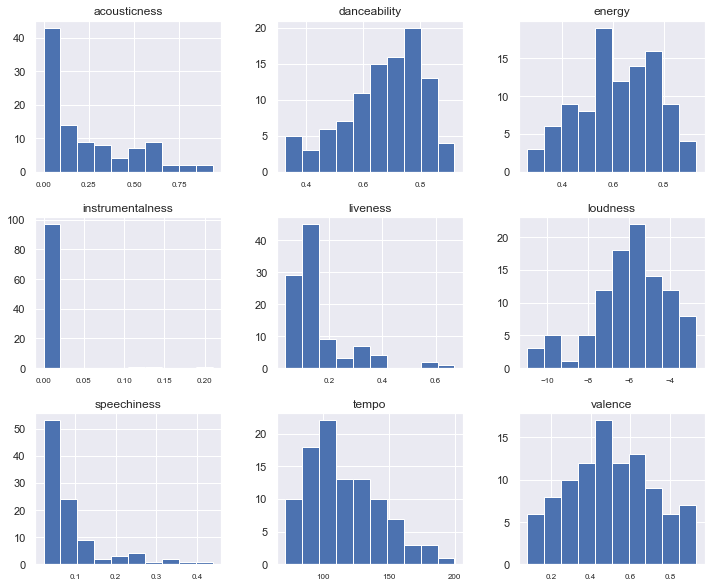

In [36]:
# Getting tracks of the playlist
tracks = sp.user_playlist_tracks(user = 'spotify', playlist_id = PLAYLIST_ID)
tracks_uri_list = [x['track']['uri'] for x in tracks['items']]

# Getting features of tracks
features = []
for i in tracks_uri_list:
    features = features + sp.audio_features(i)

# Creating feature dataframe
cols_to_drop = ['id', 'analysis_url', 'key', 'time_signature', 'track_href', 'type', 'uri', 'mode', 'duration_ms']
features_df = pd.DataFrame(features).drop(cols_to_drop, axis=1)
features_df.hist(xlabelsize=8, figsize=(12,10))


[Text(0, 0.5, 'Inertia'), Text(0.5, 0, 'Cluster Size')]

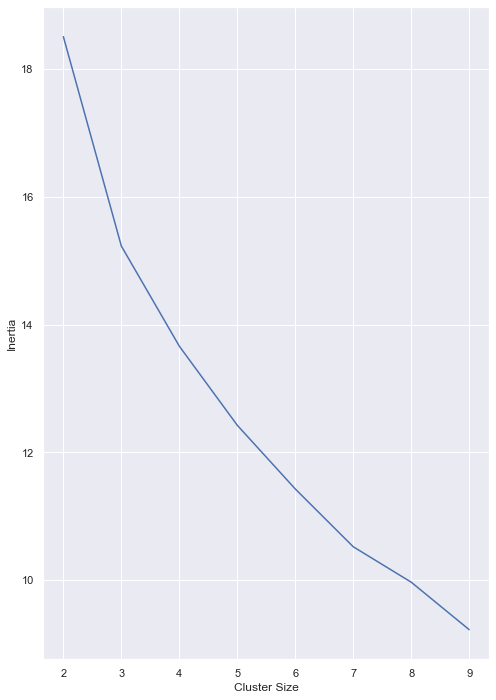

In [37]:

from sklearn.cluster import KMeans

# Scaling
for col in ['loudness', 'tempo']:
    features_df[col] = ((features_df[col] - features_df[col].min()) / (features_df[col].max() - features_df[col].min()))

# Determining the cluster size
score_list = []
for i in range(2,10):
    kmeans_model = KMeans(n_clusters=i, random_state=3).fit(features_df)
    preds = kmeans_model.predict(features_df)
    score_list.append(kmeans_model.inertia_)

# Visualization of different cluster size performations
pd.DataFrame(score_list, index=range(2, 10)).plot(legend=False).set(xlabel="Cluster Size", ylabel="Inertia")



In [38]:
# Training and Predicting
kmeans_model = KMeans(n_clusters=5, random_state=3).fit(features_df)
preds = kmeans_model.predict(features_df)


In [39]:

# Extracting song and artist names
songs = [x['track']['name'] for x in tracks['items']]
artists = [x['track']['artists'] for x in tracks['items']]

# Concatenating multiple artist names
artist_list = []
for group in artists:
    artist_group = []
    for person in group:
        artist_group.append(person['name'])
    artist_list.append(', '.join(artist_group))

# Adding predictions to dataframe
features_df['cluster'] = preds

# Grouping clusters to see the averages
clusters = features_df \
    .groupby('cluster') \
    .agg('mean')



In [40]:
clusters

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster,,,,,,,,,
0,0.715158,0.560158,0.580722,0.067811,0.108881,0.000498,0.218274,0.369695,0.229253
1,0.716459,0.738946,0.744424,0.082819,0.076911,0.003703,0.126862,0.665757,0.353479
2,0.527308,0.670462,0.658237,0.095038,0.129457,0.016566,0.208938,0.281008,0.700418
3,0.594737,0.447316,0.312305,0.151342,0.577368,0.006877,0.151779,0.347526,0.247336
4,0.756417,0.581583,0.618529,0.059675,0.516583,0.000464,0.121758,0.648583,0.292055


## Part 4: Personal music trends:

In [41]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util

from spotipy.oauth2 import SpotifyClientCredentials

In [42]:
# Authorization flow
redirect_uri='http://localhost:8000/'
scope = 'user-top-read'
token = util.prompt_for_user_token(user_id, scope, client_id=CLIENT_ID, client_secret=CLIENT_SECRET, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [43]:
# Fetch the top-50 songs of the user
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_top_tracks(limit=50,offset=0,time_range='medium_term')
    for song in range(50):
        list = []
        list.append(results)
        with open('top50_data.json', 'w', encoding='utf-8') as f:
            json.dump(list, f, ensure_ascii=False, indent=4)
else:
    print("Can't get token for", username)

In [44]:
# Open the JSON file to Python objects
with open('top50_data.json') as f:
  data = json.load(f)

In [45]:
len(data[0]['items'])

50

In [46]:
list_of_results = data[0]["items"]
list_of_artist_names = []
list_of_artist_uri = []
list_of_song_names = []
list_of_song_uri = []
list_of_durations_ms = []
list_of_explicit = []
list_of_albums = []
list_of_popularity = []

for result in list_of_results:
    result["album"]
    this_artists_name = result["artists"][0]["name"]
    list_of_artist_names.append(this_artists_name)
    this_artists_uri = result["artists"][0]["uri"]
    list_of_artist_uri.append(this_artists_uri)
    list_of_songs = result["name"]
    list_of_song_names.append(list_of_songs)
    song_uri = result["uri"]
    list_of_song_uri.append(song_uri)
    list_of_duration = result["duration_ms"]
    list_of_durations_ms.append(list_of_duration)
    song_explicit = result["explicit"]
    list_of_explicit.append(song_explicit)
    this_album = result["album"]["name"]
    list_of_albums.append(this_album)
    song_popularity = result["popularity"]
    list_of_popularity.append(song_popularity)

In [47]:
# Convert the pulled content to a pandas df
all_songs = pd.DataFrame(
    {'artist': list_of_artist_names,
     'artist_uri': list_of_artist_uri,
     'song': list_of_song_names,
     'song_uri': list_of_song_uri,
     'duration_ms': list_of_durations_ms,
     'explicit': list_of_explicit,
     'album': list_of_albums,
     'popularity': list_of_popularity
     
    })

#### Top 50 songs of the user:

In [48]:
all_songs.sort_values('popularity', ascending=False)

,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
10,blackbear,spotify:artist:2cFrymmkijnjDg9SS92EPM,hot girl bummer,spotify:track:7aiClxsDWFRQ0Kzk5KI5ku,185093,True,hot girl bummer,87
25,Alan Walker,spotify:artist:7vk5e3vY1uw9plTHJAMwjN,"Alone, Pt. II",spotify:track:0bMbDctzMmTyK2j74j3nF3,179052,False,"Alone, Pt. II",82
44,WALK THE MOON,spotify:artist:6DIS6PRrLS3wbnZsf7vYic,Shut Up and Dance,spotify:track:4kbj5MwxO1bq9wjT5g9HaA,199080,False,TALKING IS HARD,79
7,The Killers,spotify:artist:0C0XlULifJtAgn6ZNCW2eu,Mr. Brightside,spotify:track:7d8GetOsjbxYnlo6Y9e5Kw,222106,False,Hot Fuss,78
45,Shakira,spotify:artist:0EmeFodog0BfCgMzAIvKQp,Waka Waka (This Time for Africa) [The Official...,spotify:track:2Cd9iWfcOpGDHLz6tVA3G4,202626,False,Waka Waka (This Time for Africa) [The Official...,78
43,OneRepublic,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ,Didn't I,spotify:track:6ikDZX0oc8EKGj2vdMAEDv,207616,False,Didn't I,77
49,Lauv,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv,Feelings,spotify:track:0s26En1JoJhVj32vizElpA,189906,False,~how i'm feeling~,77
3,Jeremy Zucker,spotify:artist:3gIRvgZssIb9aiirIg0nI3,comethru (bonus track),spotify:track:1pV9TLnQdOHbvourRO7x4m,181613,False,love is not dying,76
35,Good Charlotte,spotify:artist:5aYyPjAsLj7UzANzdupwnS,The Anthem,spotify:track:0BRHnOFm6sjxN1i9LJrUDu,175093,False,The Young and The Hopeless,73
46,Bazzi,spotify:artist:4GvEc3ANtPPjt1ZJllr5Zl,I Got You,spotify:track:2QNndTbo9mvgOoOKJvpEl2,146832,True,I Got You,71


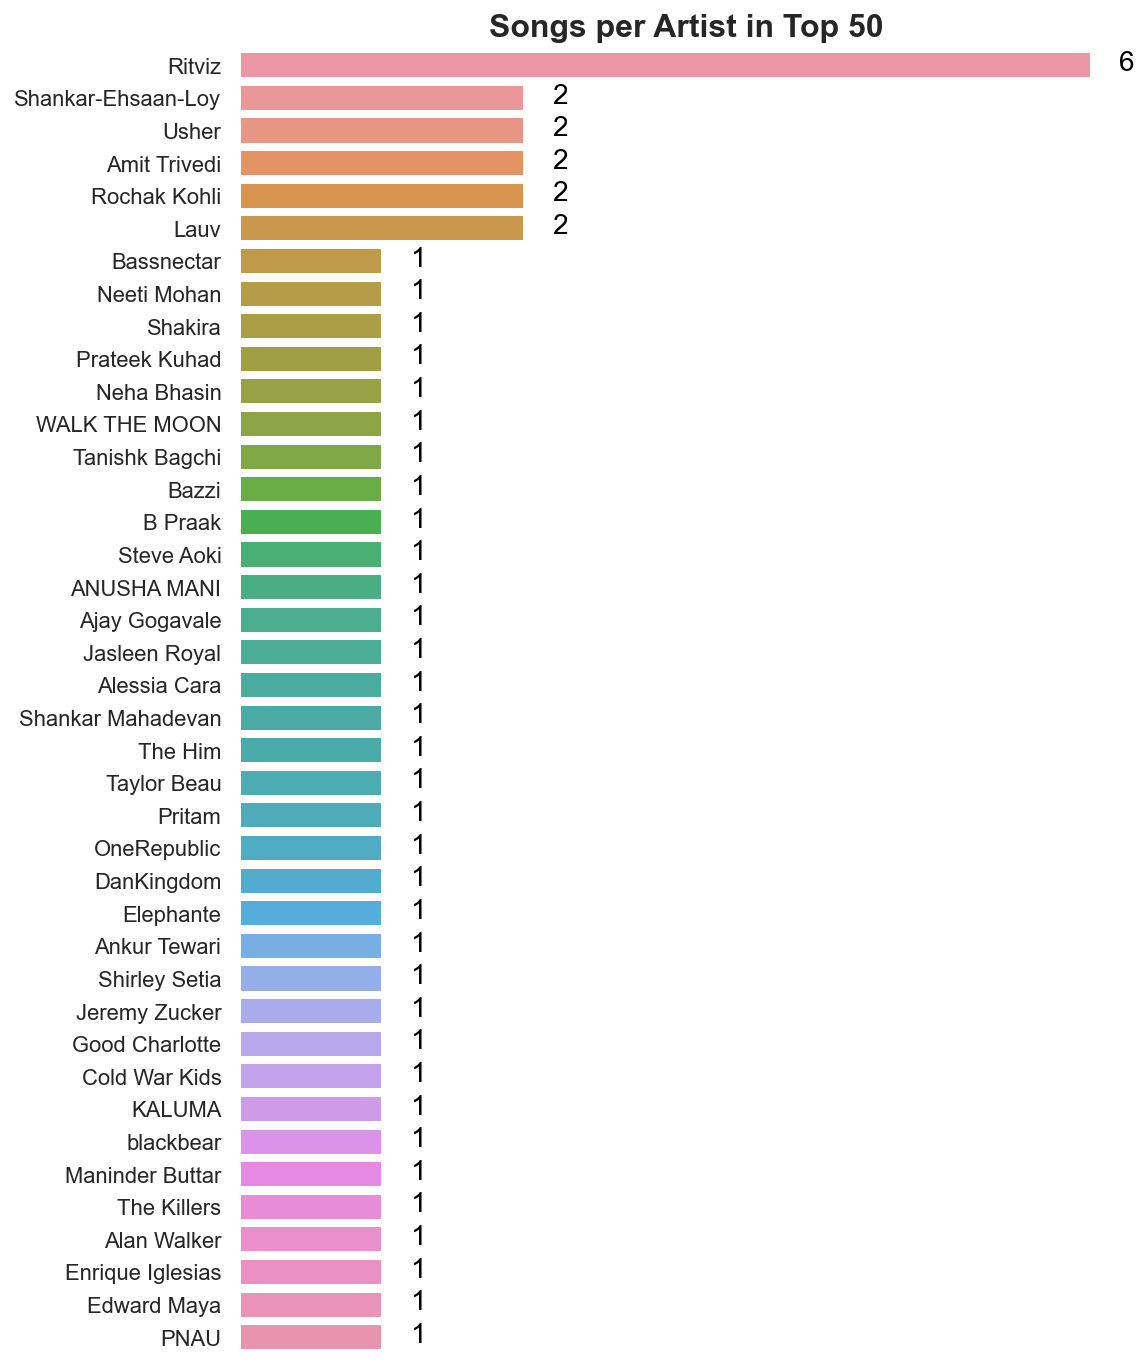

In [49]:
descending_order = all_songs['artist'].value_counts().sort_values(ascending=False).index
ax = sns.countplot(y = all_songs['artist'], order=descending_order)

sns.despine(fig=None, ax=None, top=True, right=True, left=False, trim=False)
sns.set(rc={'figure.figsize':(14,17)})

ax.set_ylabel('')    
ax.set_xlabel('')
ax.set_title('Songs per Artist in Top 50', fontsize=16, fontweight='heavy')
sns.set(font_scale = 1.4)
ax.axes.get_xaxis().set_visible(False)
ax.set_frame_on(False)

y = all_songs['artist'].value_counts()
for i, v in enumerate(y):
    ax.text(v + 0.2, i + .16, str(v), color='black', fontweight='light', fontsize=14)
    
plt.show()

In [50]:
from pandas.io.json import json_normalize

In [51]:
ARTISTS_SAMPLE_SIZE=20
ARTISTS_OFFSET=0

### Top artists for the user (short term,mid term and long term):

In [52]:
st_artists = sp.current_user_top_artists(limit=ARTISTS_SAMPLE_SIZE, offset=ARTISTS_OFFSET, time_range='short_term')
mt_artists = sp.current_user_top_artists(limit=ARTISTS_SAMPLE_SIZE, offset=ARTISTS_OFFSET, time_range='medium_term')
lt_artists = sp.current_user_top_artists(limit=ARTISTS_SAMPLE_SIZE, offset=ARTISTS_OFFSET, time_range='long_term')

In [53]:
short_term_top_artists_df = json_normalize(st_artists["items"])
medium_term_top_artists_df = json_normalize(mt_artists["items"])
long_term_top_artists_df = json_normalize(lt_artists["items"])

/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.
/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
short_term_top_artists_df = short_term_top_artists_df[['name','popularity','genres', 'followers.total', 'uri']].sort_values(by=['popularity'], ascending=False)
medium_term_top_artists_df = medium_term_top_artists_df[['name','popularity','genres', 'followers.total', 'uri']].sort_values(by=['popularity'], ascending=False)
long_term_top_artists_df = long_term_top_artists_df[['name','popularity','genres', 'followers.total', 'uri']].sort_values(by=['popularity'], ascending=False)

In [55]:
short_term_top_artists_df.head(10)

,name,popularity,genres,followers.total,uri
11,Ed Sheeran,93,"[pop, uk pop]",66484936,spotify:artist:6eUKZXaKkcviH0Ku9w2n3V
12,Marshmello,90,"[brostep, pop, progressive electro house]",25239928,spotify:artist:64KEffDW9EtZ1y2vBYgq8T
1,Kygo,90,"[edm, pop, tropical house]",6505698,spotify:artist:23fqKkggKUBHNkbKtXEls4
10,Shawn Mendes,88,"[canadian pop, dance pop, pop, post-teen pop, ...",27700418,spotify:artist:7n2wHs1TKAczGzO7Dd2rGr
4,Lauv,88,[pop],3097297,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv
16,Katy Perry,88,"[dance pop, pop, post-teen pop]",15729745,spotify:artist:6jJ0s89eD6GaHleKKya26X
6,The Chainsmokers,87,"[dance pop, edm, electropop, pop, tropical house]",16361809,spotify:artist:69GGBxA162lTqCwzJG5jLp
7,OneRepublic,87,"[dance pop, piano rock, pop, pop rock]",10206629,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ
17,Ellie Goulding,84,"[dance pop, edm, electropop, metropopolis, pop...",8125624,spotify:artist:0X2BH1fck6amBIoJhDVmmJ
8,Arijit Singh,82,"[desi pop, filmi, modern bollywood]",15830170,spotify:artist:4YRxDV8wJFPHPTeXepOstw


In [56]:
medium_term_top_artists_df.head(10)


,name,popularity,genres,followers.total,uri
15,Taylor Swift,92,"[dance pop, pop, post-teen pop]",30581821,spotify:artist:06HL4z0CvFAxyc27GXpf02
2,Kygo,90,"[edm, pop, tropical house]",6505698,spotify:artist:23fqKkggKUBHNkbKtXEls4
14,Maroon 5,89,"[pop, pop rock]",25566661,spotify:artist:04gDigrS5kc9YWfZHwBETP
6,Lauv,88,[pop],3097297,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv
13,Shawn Mendes,88,"[canadian pop, dance pop, pop, post-teen pop, ...",27700418,spotify:artist:7n2wHs1TKAczGzO7Dd2rGr
17,Katy Perry,88,"[dance pop, pop, post-teen pop]",15729745,spotify:artist:6jJ0s89eD6GaHleKKya26X
8,OneRepublic,87,"[dance pop, piano rock, pop, pop rock]",10206629,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ
9,The Chainsmokers,87,"[dance pop, edm, electropop, pop, tropical house]",16361809,spotify:artist:69GGBxA162lTqCwzJG5jLp
4,Avicii,86,"[big room, dance pop, edm, pop]",17756092,spotify:artist:1vCWHaC5f2uS3yhpwWbIA6
16,Arijit Singh,82,"[desi pop, filmi, modern bollywood]",15830170,spotify:artist:4YRxDV8wJFPHPTeXepOstw


In [57]:
long_term_top_artists_df.head(10)


,name,popularity,genres,followers.total,uri
2,Marshmello,90,"[brostep, pop, progressive electro house]",25239928,spotify:artist:64KEffDW9EtZ1y2vBYgq8T
8,Kygo,90,"[edm, pop, tropical house]",6505698,spotify:artist:23fqKkggKUBHNkbKtXEls4
6,Lauv,88,[pop],3097297,spotify:artist:5JZ7CnR6gTvEMKX4g70Amv
16,OneRepublic,87,"[dance pop, piano rock, pop, pop rock]",10206629,spotify:artist:5Pwc4xIPtQLFEnJriah9YJ
1,The Chainsmokers,87,"[dance pop, edm, electropop, pop, tropical house]",16361809,spotify:artist:69GGBxA162lTqCwzJG5jLp
13,Alan Walker,86,[electro house],22517291,spotify:artist:7vk5e3vY1uw9plTHJAMwjN
14,Avicii,86,"[big room, dance pop, edm, pop]",17756092,spotify:artist:1vCWHaC5f2uS3yhpwWbIA6
17,Ellie Goulding,84,"[dance pop, edm, electropop, metropopolis, pop...",8125624,spotify:artist:0X2BH1fck6amBIoJhDVmmJ
10,Arijit Singh,82,"[desi pop, filmi, modern bollywood]",15830170,spotify:artist:4YRxDV8wJFPHPTeXepOstw
3,Steve Aoki,80,"[big room, dance pop, edm, electro house, trop...",3407060,spotify:artist:77AiFEVeAVj2ORpC85QVJs


### Top user tracks (short term,mid term and long term):

In [58]:
TRACKS_SAMPLE_SIZE = 1000
TRACKS_OFFSET = 0

In [59]:
st_tracks = sp.current_user_top_tracks(limit=TRACKS_SAMPLE_SIZE, offset=TRACKS_OFFSET, time_range='short_term')
mt_tracks = sp.current_user_top_tracks(limit=TRACKS_SAMPLE_SIZE, offset=TRACKS_OFFSET, time_range='medium_term')
lt_tracks = sp.current_user_top_tracks(limit=TRACKS_SAMPLE_SIZE, offset=TRACKS_OFFSET, time_range='long_term')

In [60]:

short_term_top_tracks_df = json_normalize(st_tracks["items"])
medium_term_top_tracks_df = json_normalize(mt_tracks["items"])
long_term_top_tracks_df = json_normalize(lt_tracks["items"])

/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  """Entry point for launching an IPython kernel.
/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  
/Users/vidhigandhi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [61]:
properNameFunc = lambda raw_col_value: raw_col_value[0]['name']

short_term_top_tracks_df = short_term_top_tracks_df[['artists', 'name','popularity', 'id', 'duration_ms', 'album.name', 'album.release_date']].sort_values(by=['popularity'], ascending=False)
medium_term_top_tracks_df = medium_term_top_tracks_df[['artists', 'name','popularity', 'id', 'duration_ms', 'album.name', 'album.release_date']].sort_values(by=['popularity'], ascending=False)
long_term_top_tracks_df = long_term_top_tracks_df[['artists', 'name','popularity', 'id', 'duration_ms', 'album.name', 'album.release_date']].sort_values(by=['popularity'], ascending=False)

short_term_top_tracks_df['artists'] = short_term_top_tracks_df['artists'].apply(properNameFunc)
medium_term_top_tracks_df['artists'] = medium_term_top_tracks_df['artists'].apply(properNameFunc)
long_term_top_tracks_df['artists'] = long_term_top_tracks_df['artists'].apply(properNameFunc)

In [62]:
short_term_top_tracks_df.head(10)

,artists,name,popularity,id,duration_ms,album.name,album.release_date
7,blackbear,hot girl bummer,87,7aiClxsDWFRQ0Kzk5KI5ku,185093,hot girl bummer,2019-08-23
29,Alan Walker,"Alone, Pt. II",82,0bMbDctzMmTyK2j74j3nF3,179052,"Alone, Pt. II",2019-12-27
40,WALK THE MOON,Shut Up and Dance,79,4kbj5MwxO1bq9wjT5g9HaA,199080,TALKING IS HARD,2014-12-02
19,The Killers,Mr. Brightside,78,7d8GetOsjbxYnlo6Y9e5Kw,222106,Hot Fuss,2004-06-07
25,Lauv,Feelings,77,0s26En1JoJhVj32vizElpA,189906,~how i'm feeling~,2020-03-06
8,Jeremy Zucker,comethru (bonus track),76,1pV9TLnQdOHbvourRO7x4m,181613,love is not dying,2020-04-17
39,Kygo,Like It Is,73,4dyrqiXUcK29hzrL2elqO3,183067,Golden Hour,2020-05-29
35,Kygo,Freedom,71,2nx0EIlIKMnMgWnj40O0HQ,198635,Golden Hour,2020-05-29
20,Bazzi,I Got You,71,2QNndTbo9mvgOoOKJvpEl2,146832,I Got You,2020-04-17
24,Tanishk Bagchi,Makhna,70,0ZHILXmUaVSLEOCWxPQ1ga,183000,"Makhna (From ""Drive"")",2019-10-03


In [63]:
medium_term_top_tracks_df.head(10)


,artists,name,popularity,id,duration_ms,album.name,album.release_date
10,blackbear,hot girl bummer,87,7aiClxsDWFRQ0Kzk5KI5ku,185093,hot girl bummer,2019-08-23
25,Alan Walker,"Alone, Pt. II",82,0bMbDctzMmTyK2j74j3nF3,179052,"Alone, Pt. II",2019-12-27
44,WALK THE MOON,Shut Up and Dance,79,4kbj5MwxO1bq9wjT5g9HaA,199080,TALKING IS HARD,2014-12-02
7,The Killers,Mr. Brightside,78,7d8GetOsjbxYnlo6Y9e5Kw,222106,Hot Fuss,2004-06-07
45,Shakira,Waka Waka (This Time for Africa) [The Official...,78,2Cd9iWfcOpGDHLz6tVA3G4,202626,Waka Waka (This Time for Africa) [The Official...,2010-05-07
43,OneRepublic,Didn't I,77,6ikDZX0oc8EKGj2vdMAEDv,207616,Didn't I,2020-03-13
49,Lauv,Feelings,77,0s26En1JoJhVj32vizElpA,189906,~how i'm feeling~,2020-03-06
3,Jeremy Zucker,comethru (bonus track),76,1pV9TLnQdOHbvourRO7x4m,181613,love is not dying,2020-04-17
35,Good Charlotte,The Anthem,73,0BRHnOFm6sjxN1i9LJrUDu,175093,The Young and The Hopeless,2002-10-04
46,Bazzi,I Got You,71,2QNndTbo9mvgOoOKJvpEl2,146832,I Got You,2020-04-17


In [65]:
long_term_top_tracks_df.head(3)

,artists,name,popularity,id,duration_ms,album.name,album.release_date
38,Post Malone,Circles,91,21jGcNKet2qwijlDFuPiPb,215280,Hollywood's Bleeding,2019-09-06
12,Billie Eilish,bad guy,90,2Fxmhks0bxGSBdJ92vM42m,194087,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",2019-03-29
11,Maroon 5,Memories,90,2b8fOow8UzyDFAE27YhOZM,189486,Memories,2019-09-20
